In [ ]:
# Tarun Bezawada - 24141881, Kedhar Eashwar Seetammagari - 24165409
# The code executes without any error

<div>
<img src="https://www.ul.ie/themes/custom/ul/logo.jpg" />
</div>

# **MSc in Artificial Intelligence and Machine Learning**
## CS6482 - Deep Reinforcement Learning
### Assignment 1: Sem2 AY 24/25 - Convolutional Neural Networks (CNNs)

Module Leader: J.J. Collins

Students:  
- Tarun Bezawada - 24141771
- Kedhar Eashwar Seetammagari - 24165409



---



# EfficientNetB0-based Caltech256 Classification Project

This project implements an image classification model on the Caltech256 dataset using a state-of-the-art CNN architecture (EfficientNetB0) as the base model, along with a custom classification head. The notebook includes:

1. **Installation and Dataset Download**
2. **Importing Libraries**
3. **Global Parameters and Setup**
4. **Data Loading**
5. **Data Visualization**
6. **Data Augmentation**
7. **Model Building and Fine-Tuning**
8. **Callbacks and Model Compilation**
9. **Model Training**
10. **Evaluation on Test Set**
11. **Additional Evaluation Metrics**
12. **Plot Training History**
13. **Display Sample Predictions**


# 1. Installation and Dataset Download

We use `opendatasets` to download the Caltech256 dataset from Kaggle.

In [ ]:
# --- Install and Download Dependencies ---
!pip install opendatasets
import opendatasets as od

In [ ]:
# --- Download the Dataset from Kaggle ---

od.download("https://www.kaggle.com/datasets/jessicali9530/caltech256/data")

# Username: kedhareashwar
# key : 13cb6fd5193998c5d74b08ec250a5965

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: kedhareashwar
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/jessicali9530/caltech256


100%|██████████| 2.12G/2.12G [00:29<00:00, 78.5MB/s]



#2. Importing Libraries

The following libraries are imported for:
- Building and training the CNN (TensorFlow, Keras).
- Image pre-processing and data augmentation.
- Model evaluation (scikit-learn for confusion matrix, classification report, etc.).
- Visualization (Matplotlib and Seaborn).


In [ ]:
# --- Import Libraries ---
# Explanation:
# These libraries are used for building the CNN, data augmentation,
# image pre-processing, model training, evaluation, and visualization.
import opendatasets as od
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np
from sklearn.model_selection import KFold, train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns  # For confusion matrix visualization

#3. Global Parameters and Setup

We define key global parameters such as:
- `num_classes_caltech256`: Number of classes (256 plus an extra if present).
- `target_size`: We use 108×108 to manage memory (trade-off between resolution and resource constraints).


In [ ]:
# --- Global Parameters ---
num_classes_caltech256 = 257  # 256 classes plus one extra
# Note: Although EfficientNetB0's default input is 224x224, we use 108x108 here to manage memory.
target_size = (108, 108)  # trade-off between resolution and RAM usage.


#4. Data Loading

Images and labels are loaded from the Caltech256 dataset. We load the first 30 images per class for training and the remaining images for testing. This approach is documented below:

- **Directory structure:** Each class is stored in its own folder.
- **Resizing:** Images are resized to `target_size` (108×108) to manage memory.
- **Label Encoding:** Labels are one-hot encoded.



In [ ]:
# --- Data Loading ---
# Load the class names from the dataset directory.
root_dir = "./caltech256/256_ObjectCategories"
class_names = sorted(os.listdir(root_dir))
print("Number of classes:", len(class_names))
# This prints the number of classes to confirm that the dataset structure is as expected.


Number of classes: 257


#5. Data Visualization

To ensure that the dataset is correctly loaded and to analyze class distribution, we:
- Plot sample images from the training set.
- Plot a bar chart of class frequencies.




In [ ]:
# Load images and labels into lists.
# We use the first 30 images per class for training and the rest for testing.
train_images = []
test_images = []
train_labels = []
test_labels = []

# Iterate over each class folder.
for label, class_name in enumerate(class_names):
    counter = 0
    print("Loading class:", class_name)
    class_path = os.path.join(root_dir, class_name)
    for filename in os.listdir(class_path):
        if filename.endswith('.jpg'):
            img_path = os.path.join(class_path, filename)
            # load_img resizes image to target_size.
            image = load_img(img_path, target_size=target_size)
            image = img_to_array(image)
            if counter < 30:
                train_images.append(image)
                train_labels.append(label)
            else:
                test_images.append(image)
                test_labels.append(label)
            counter += 1



Loading class: 001.ak47
Loading class: 002.american-flag
Loading class: 003.backpack
Loading class: 004.baseball-bat
Loading class: 005.baseball-glove
Loading class: 006.basketball-hoop
Loading class: 007.bat
Loading class: 008.bathtub
Loading class: 009.bear
Loading class: 010.beer-mug
Loading class: 011.billiards
Loading class: 012.binoculars
Loading class: 013.birdbath
Loading class: 014.blimp
Loading class: 015.bonsai-101
Loading class: 016.boom-box
Loading class: 017.bowling-ball
Loading class: 018.bowling-pin
Loading class: 019.boxing-glove
Loading class: 020.brain-101
Loading class: 021.breadmaker
Loading class: 022.buddha-101
Loading class: 023.bulldozer
Loading class: 024.butterfly
Loading class: 025.cactus
Loading class: 026.cake
Loading class: 027.calculator
Loading class: 028.camel
Loading class: 029.cannon
Loading class: 030.canoe
Loading class: 031.car-tire
Loading class: 032.cartman
Loading class: 033.cd
Loading class: 034.centipede
Loading class: 035.cereal-box
Loading 

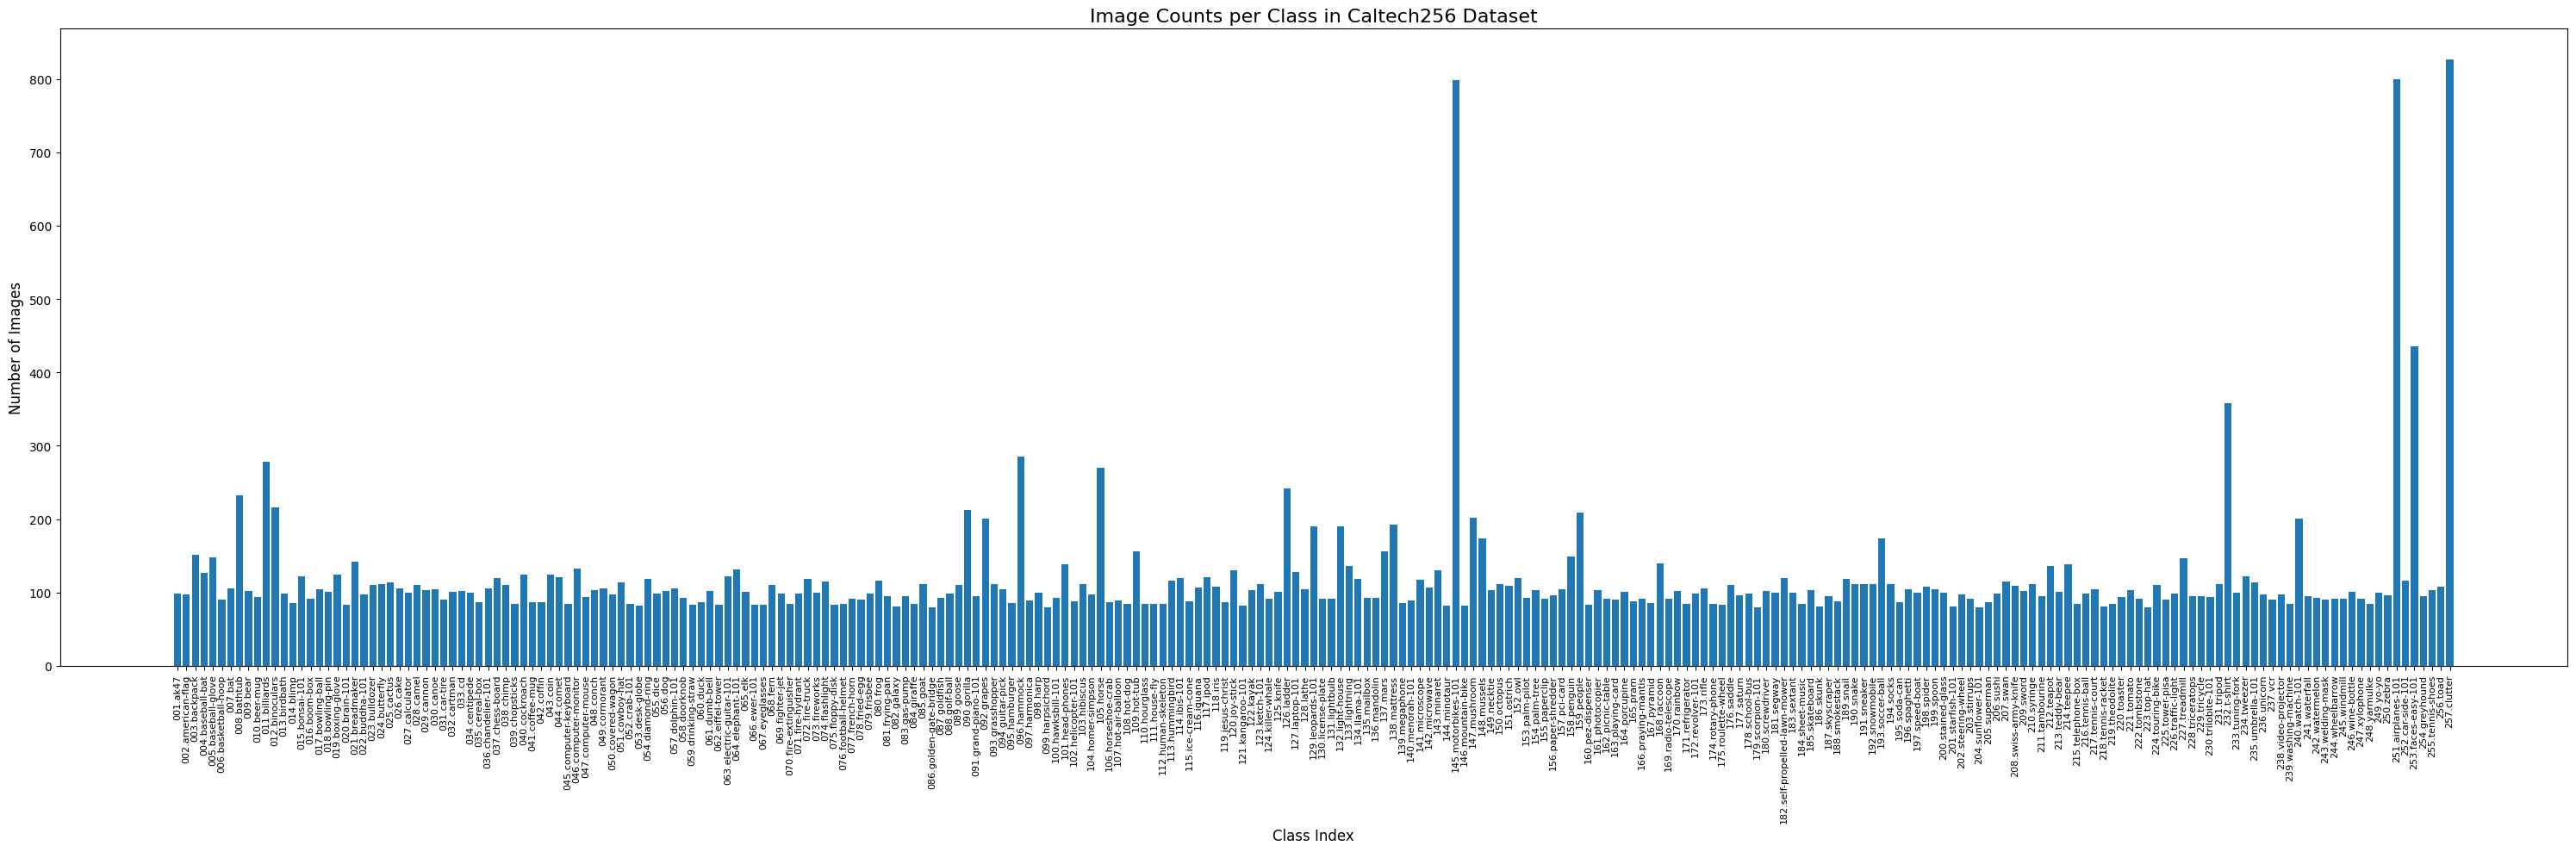

In [ ]:
# --- Count Images per Class ---
class_image_counts = []
for class_name in class_names:
    class_path = os.path.join(root_dir, class_name)
    image_count = len([f for f in os.listdir(class_path) if f.endswith('.jpg')])
    class_image_counts.append(image_count)

# --- Visualization ---
plt.figure(figsize=(30, 10))
plt.bar(range(len(class_names)), class_image_counts)
plt.title('Image Counts per Class in Caltech256 Dataset', fontsize=16)
plt.xlabel('Class Index', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)

# Rotate x-axis labels for better visibility
plt.xticks(range(len(class_names)), class_names, rotation=90, fontsize=8)

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [ ]:
# Convert the image lists to numpy arrays for further processing.
train_images = np.array(train_images)
test_images = np.array(test_images)

# Convert labels to one-hot encoded vectors
train_labels = to_categorical(train_labels, num_classes=num_classes_caltech256)
test_labels = to_categorical(test_labels, num_classes=num_classes_caltech256)
# This one-hot encoding is necessary for categorical crossentropy loss.


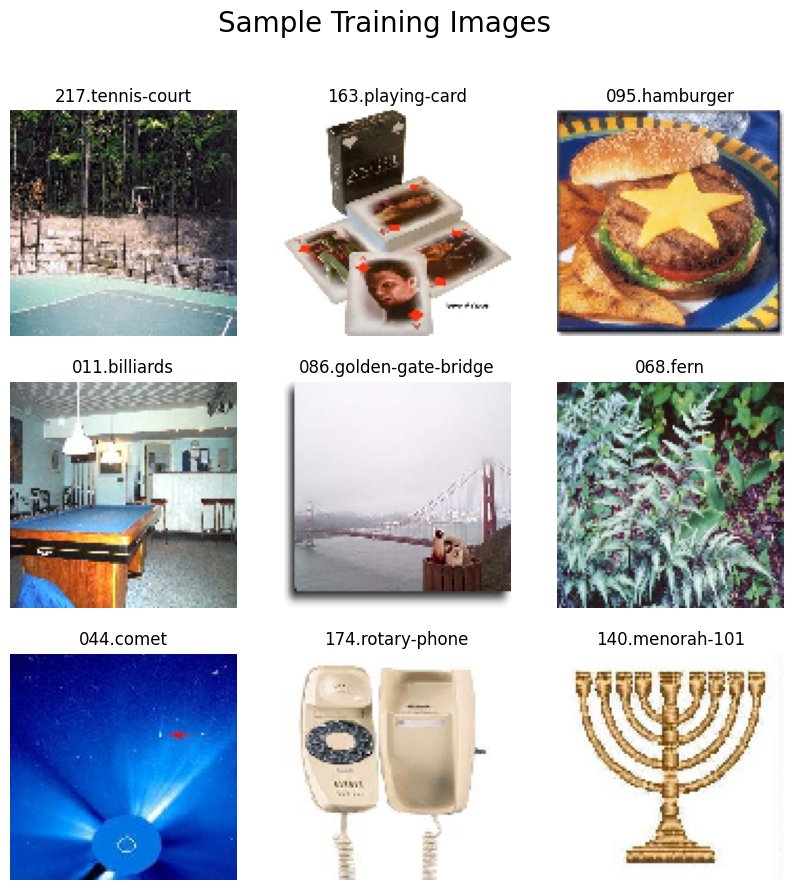

In [ ]:
# --- Data Visualization ---
# Plot a few sample training images to visually inspect the data.
plt.figure(figsize=(10, 10))
plt.suptitle("Sample Training Images", fontsize=20)
for i in range(9):
    plt.subplot(3, 3, i + 1)
    random_index = np.random.randint(0, len(train_images))
    plt.imshow(train_images[random_index].astype('uint8'))
    plt.title(class_names[np.argmax(train_labels[random_index])])
    plt.axis('off')
plt.show()
# Visualizing the dataset helps ensure that the images are loaded and preprocessed correctly.


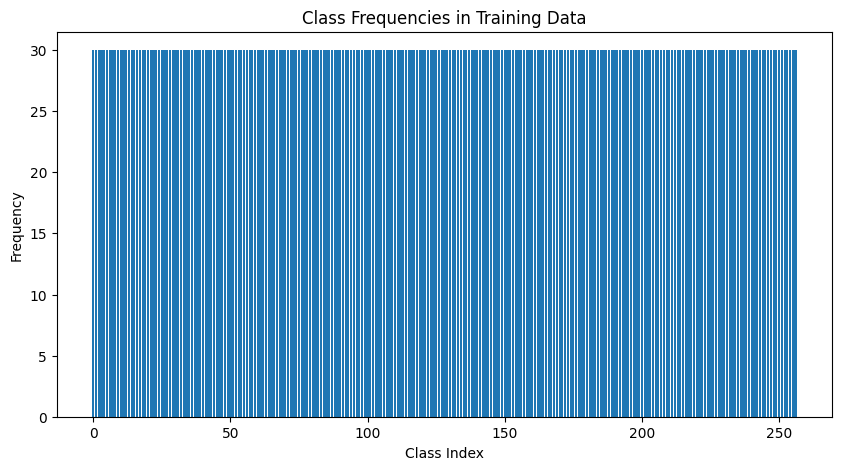

In [ ]:
# Plot class distribution to show data balance.
class_frequencies = np.sum(train_labels, axis=0)
plt.figure(figsize=(10, 5))
plt.bar(range(num_classes_caltech256), class_frequencies)
plt.title('Class Frequencies in Training Data')
plt.xlabel('Class Index')
plt.ylabel('Frequency')
plt.show()

#6. Data Augmentation

Data augmentation is applied to the training set using `ImageDataGenerator` with the following transformations:
- Rotation, width/height shifts, shear, zoom.
- Horizontal flip and brightness adjustments.

This increases data variability and helps reduce overfitting, satisfying the assignment guidelines.


In [ ]:
# --- Split Data into Training and Validation Sets ---
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42
)

# --- Data Augmentation ---
# Augment the training images to increase data diversity and reduce overfitting.
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

# For validation, we only preprocess without augmentation.
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create data generators from the augmented data.
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
validation_generator = validation_datagen.flow(
    X_val, y_val, batch_size=32, shuffle=False
)
# Generators ensure that data augmentation is applied on the fly, increasing effective training data size.



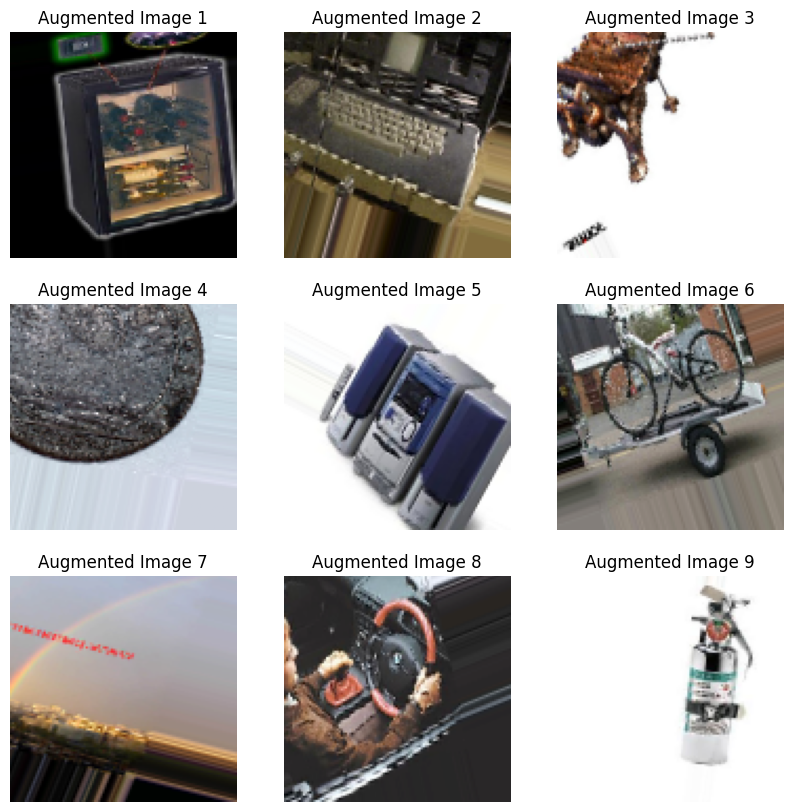

In [ ]:
# Get a batch of augmented images from the train_generator
augmented_images, labels = next(train_generator)

# Display a few augmented images (e.g., the first 9)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    # Since the images are preprocessed, we need to convert them back to the original range for display
    image = augmented_images[i]
    image = image - image.min()  # Shift to positive values
    image = image / image.max()  # Normalize to 0-1
    plt.imshow(image)
    plt.title(f"Augmented Image {i+1}")
    plt.axis('off')
plt.show()

#7. Model Building and Fine-Tuning
EfficientNet is a family of convolutional neural network (CNN) architectures that achieve state-of-the-art accuracy while being computationally efficient. Developed by [Mingxing Tan and Quoc V. Le](https://arxiv.org/abs/1905.11946), EfficientNet models use a compound scaling method that uniformly scales network depth, width, and input resolution. The baseline model, EfficientNet-B0, is designed to provide a strong balance between accuracy and efficiency, making it well-suited for tasks where resources are limited. Its architecture leverages advanced techniques like squeeze-and-excitation optimization and swish activation functions, contributing to improved performance over conventional architectures such as ResNet or MobileNet. This efficiency makes it a popular choice for transfer learning and fine-tuning on various image classification tasks.

We use EfficientNetB0 as our base model, pre-trained on ImageNet, without the top classification layers.


<img src="https://www.researchgate.net/publication/356981443/figure/fig3/AS:1100238135791616@1639328621231/Architecture-of-EfficientNet-B0-with-MBConv-as-Basic-building-blocks.png">

*EfficientNetB0 representation from [ResearchGate](https://www.researchgate.net/figure/architecture-of-EfficientNet-B0-with-MBConv-as-Basic-building-blocks_fig3_356981443)*







To adapt to the Caltech256 data:
- We set the input shape to (108, 108, 3).
- We freeze all but the last 3 layers of EfficientNetB0 for fine-tuning.
- A custom classification head is added, consisting of:
  - Flattening the CNN output.
  - Two Dense layers with 1024 units each, with ReLU activation.
  - Dropout layers (0.6) and L2 regularization (0.005) to prevent overfitting.
  - A final softmax layer outputs class probabilities.

In [ ]:
# --- Model Building with EfficientNetB0 ---
# Load EfficientNetB0 without its top layers; this serves as the feature extractor.
efficientnet = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(108, 108, 3))
# Fine-tuning: Freeze all but the last 3 layers so that the model retains learned features and adapts slightly to the new data.
for layer in efficientnet.layers[:-3]:
    layer.trainable = False
for layer in efficientnet.layers[-3:]:
    layer.trainable = True


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# --- Classification Head ---
# Flatten the output of EfficientNetB0, then add fully connected layers.
x = Flatten()(efficientnet.output)
x = Dense(1024, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.005))(x)
x = Dropout(0.6)(x)  # Dropout for regularization.
x = Dense(1024, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.005))(x)
x = Dropout(0.6)(x)
# Final softmax layer outputs probability distribution over classes.
x = Dense(num_classes_caltech256, activation="softmax", name="class_label")(x)


In [ ]:
# Define the final model
model = tf.keras.models.Model(inputs=efficientnet.input, outputs=x)
# (using a state-of-the-art architecture, EfficientNetB0) with a custom classification head.

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 108, 108, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 108, 108, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 108, 108, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 108, 108, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 109, 109, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 54, 54, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 54, 54, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 54, 54, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 54, 54, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 54, 54, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 54, 54, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 26,335,140 (100.46 MB)

 Trainable params: 22,697,729 (86.58 MB)

 Non-trainable params: 3,637,411 (13.88 MB)

#8. Callbacks and Model Compilation

We use the following callbacks:
- **ReduceLROnPlateau:** To reduce the learning rate if the validation loss does not improve.
- **EarlyStopping:** To stop training if the validation loss stagnates for too long.

We compile the model using:
- **Loss Function:** Categorical Crossentropy with label smoothing (0.1) to improve generalization.
- **Optimizer:** Adam with a learning rate of 5e-5.


In [ ]:
# --- Callbacks ---
# Callbacks help in dynamically adjusting the learning rate and stopping training when performance stagnates.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)


In [ ]:
# --- Model Compilation ---
# We use Categorical Crossentropy with label smoothing as the loss function.
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
# Adam optimizer with a learning rate of 5e-5 is used.
model.compile(optimizer=Adam(learning_rate=5e-5),
              loss=loss,
              metrics=['accuracy'])


In [ ]:
# Print the loss function and optimiser configuration
print("Loss Function:", model.loss)
print("Optimizer Configuration:", model.optimizer.get_config())

Loss Function: <LossFunctionWrapper(<function categorical_crossentropy at 0x7e51b1c46a20>, kwargs={'from_logits': False, 'label_smoothing': 0.1, 'axis': -1})>
Optimizer Configuration: {'name': 'adam', 'learning_rate': 4.999999873689376e-05, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 108, 108, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 108, 108, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 108, 108, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 108, 108, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 109, 109, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 54, 54, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 54, 54, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 54, 54, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 54, 54, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 54, 54, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 54, 54, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 26,335,140 (100.46 MB)

 Trainable params: 22,697,729 (86.58 MB)

 Non-trainable params: 3,637,411 (13.88 MB)

#9. Model Training

The model is trained on the augmented training data using the training generator, while validation is done on the non-augmented validation set. Training progress (accuracy and loss) is monitored over 100 epochs, with callbacks applied.


In [ ]:

# --- Model Training ---
history_final = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[reduce_lr, early_stopping]
)
# Training the model on the augmented data with validation ensures that we can monitor performance improvements.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 72s 241ms/step - accuracy: 0.0039 - loss: 21.1855 - val_accuracy: 0.0396 - val_loss: 19.7237 - learning_rate: 5.0000e-05
Epoch 2/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 24s 124ms/step - accuracy: 0.0094 - loss: 19.9098 - val_accuracy: 0.1057 - val_loss: 19.0630 - learning_rate: 5.0000e-05
Epoch 3/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 24s 125ms/step - accuracy: 0.0161 - loss: 19.1358 - val_accuracy: 0.1881 - val_loss: 18.3718 - learning_rate: 5.0000e-05
Epoch 4/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 25s 130ms/step - accuracy: 0.0237 - loss: 18.4436 - val_accuracy: 0.2406 - val_loss: 17.6508 - learning_rate: 5.0000e-05
Epoch 5/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 24s 124ms/step - accuracy: 0.0449 - loss: 17.7247 - val_accuracy: 0.2860 - val_loss: 16.8887 - learning_rate: 5.0000e-05
Epoch 6/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 24s 124ms/step - accuracy: 0.0738 - loss: 16.9943 - val_accuracy: 0.3145 - val_loss: 16.0437 - learning_rate: 5.0000e-05
Epoch 7/100
193/193 ━━━━━━━━

In [ ]:
import pickle
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the paths to save the model and history
model_save_path = '/content/drive/MyDrive/caltech256_model.h5'
history_save_path = '/content/drive/MyDrive/caltech256_history.pkl'

# Save the model
model.save(model_save_path)

# Save the training history
with open(history_save_path, 'wb') as file:
    pickle.dump(history_final.history, file)

print("Model and history saved to Google Drive.")

Mounted at /content/drive
Model and history saved to Google Drive.


#10. Evaluation on Test Set

After training, the model is evaluated on the test set using a test generator. This evaluation provides an unbiased estimate of the model's performance on unseen data.

In [ ]:
# --- Evaluation on Test Set ---
# Create a test generator to preprocess test images without augmentation.
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow(test_images, test_labels, batch_size=32, shuffle=False)
metrics = model.evaluate(test_generator, verbose=0)
print(f'Test Loss: {metrics[0]:.4f} | Test Accuracy: {metrics[1]*100:.2f}%')
# This evaluation step provides an unbiased estimate of the model’s performance on unseen data.


Test Loss: 3.3979 | Test Accuracy: 68.36%


#11. Additional Evaluation Metrics

To further evaluate model performance, we compute:
- **Confusion Matrix:** Shows the distribution of correct and incorrect predictions across classes.
- **Classification Report:** Includes precision, recall, and F1-score for each class.


In [ ]:
# --- Additional Evaluation Metrics ---
# Compute confusion matrix and classification report for deeper evaluation (precision, recall, F1 score, etc.)

# Generate predictions using the final model.
test_preds_prob = model.predict(test_generator)
test_preds = np.argmax(test_preds_prob, axis=1)
true_test = np.argmax(test_labels, axis=1)

# Compute confusion matrix.
conf_matrix = confusion_matrix(true_test, test_preds)
print("Confusion Matrix:")
print(conf_matrix)


# Print classification report (includes precision, recall, F1-score).
class_report = classification_report(true_test, test_preds, target_names=class_names, zero_division=0)
print("Classification Report:")
print(class_report)

# overall precision, recall, and F1 score.
overall_precision = precision_score(true_test, test_preds, average='weighted', zero_division=0)
overall_recall = recall_score(true_test, test_preds, average='weighted', zero_division=0)
overall_f1 = f1_score(true_test, test_preds, average='weighted', zero_division=0)
print(f"Overall Precision: {overall_precision:.4f}")
print(f"Overall Recall:    {overall_recall:.4f}")
print(f"Overall F1 Score:  {overall_f1:.4f}")

716/716 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step
Confusion Matrix:
[[ 52   0   0 ...   0   0   0]
 [  0  55   0 ...   0   0   0]
 [  0   0  98 ...   0   0   0]
 ...
 [  0   0   1 ...  48   0   0]
 [  0   0   0 ...   0  64   0]
 [  1  11   0 ...   1   3 202]]
Classification Report:
                               precision    recall  f1-score   support

                     001.ak47       0.68      0.76      0.72        68
            002.american-flag       0.73      0.82      0.77        67
                 003.backpack       0.77      0.81      0.79       121
             004.baseball-bat       0.63      0.35      0.45        97
           005.baseball-glove       0.80      0.72      0.76       118
          006.basketball-hoop       0.56      0.55      0.55        60
                      007.bat       0.60      0.28      0.38        76
                  008.bathtub       0.83      0.63      0.72       202
                     009.bear       0.57      0.75      0.65        72
             

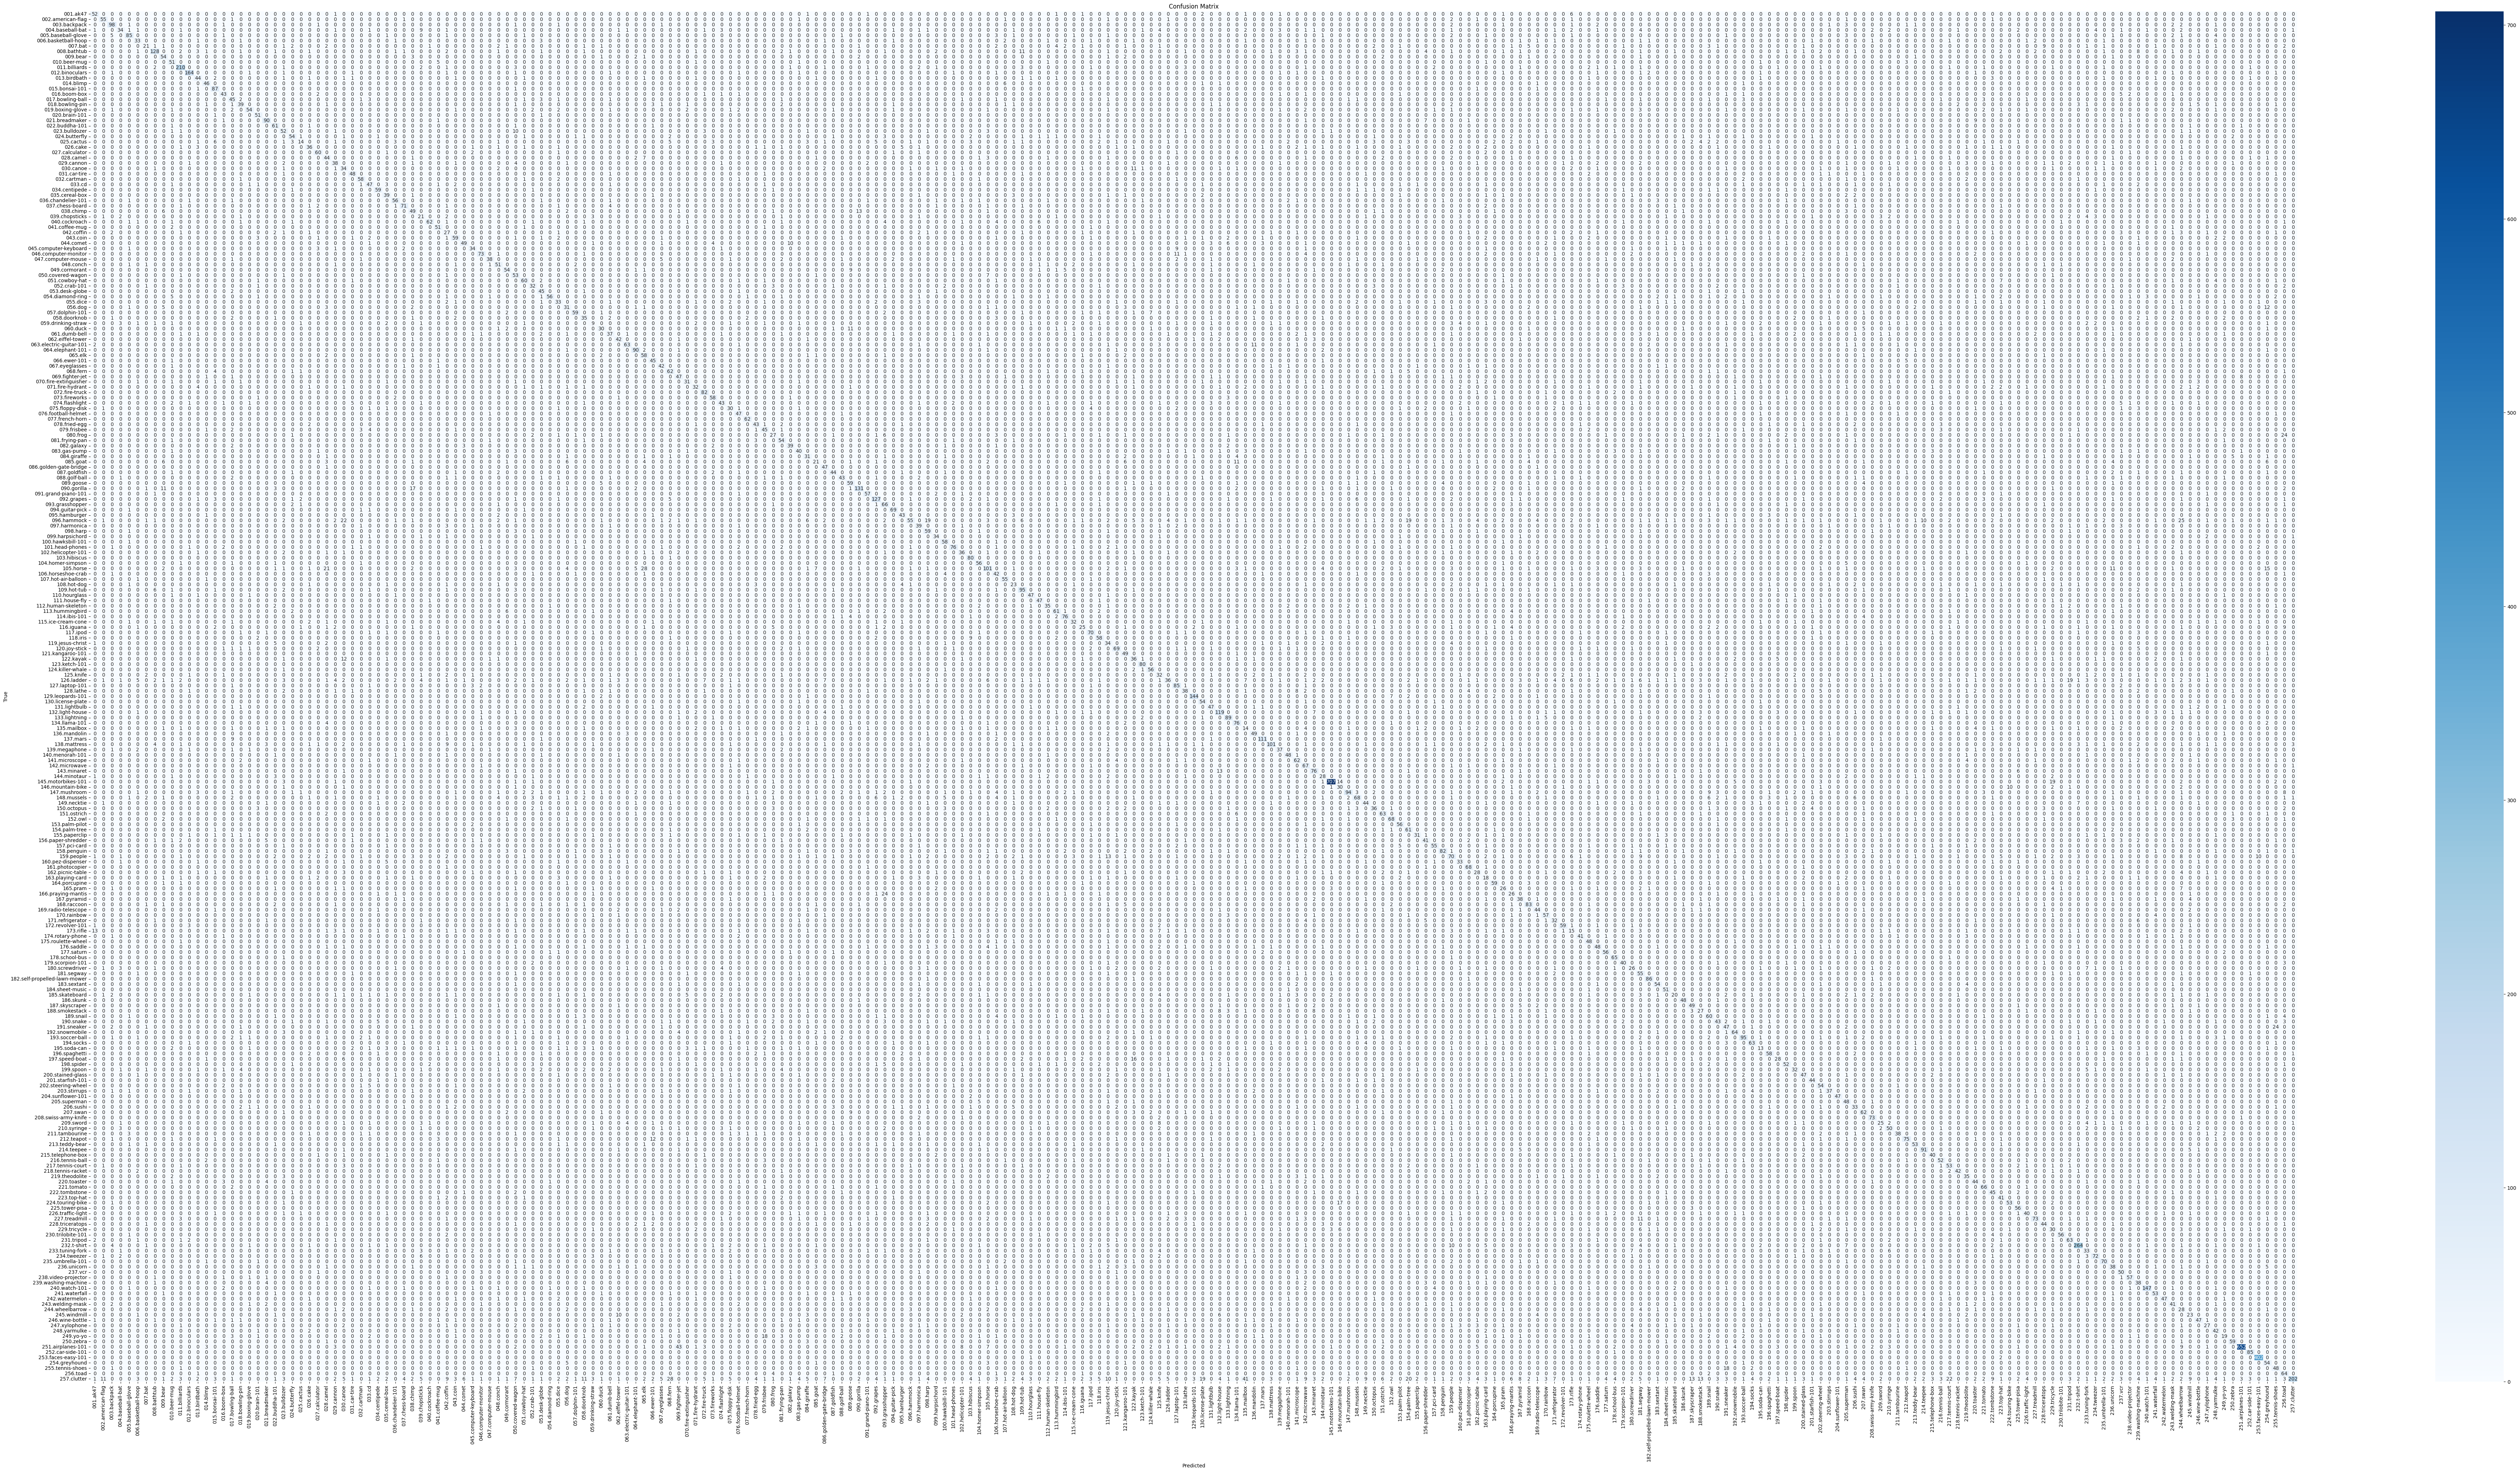

In [ ]:
# Visualize the confusion matrix.
plt.figure(figsize=(100, 50))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


#12. Plot Training History

The following plots show:
- Training and validation accuracy over epochs.
- Training and validation loss over epochs.

These plots help visualize the learning process and verify convergence.


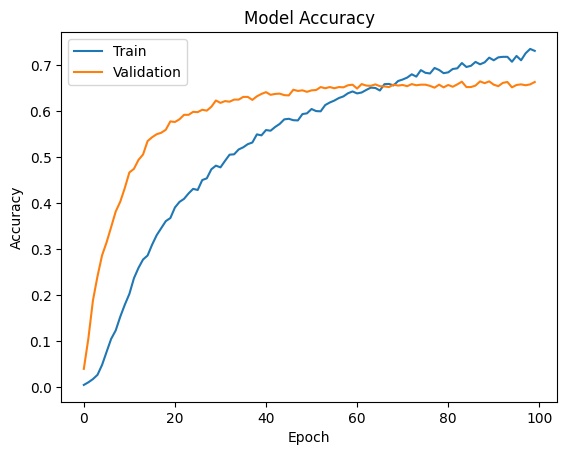

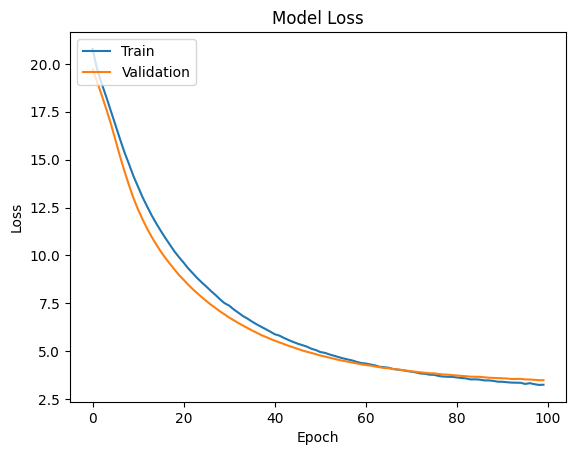

In [ ]:
# --- Plot Training History ---

# Plot training & validation accuracy values
plt.figure()
plt.plot(history_final.history['accuracy'])
plt.plot(history_final.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure()
plt.plot(history_final.history['loss'])
plt.plot(history_final.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


#13. Display Sample Predictions

Finally, we display predictions on 10 random test images with their predicted labels, confidence scores, and true labels. This qualitative result supports the quantitative evaluation.


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


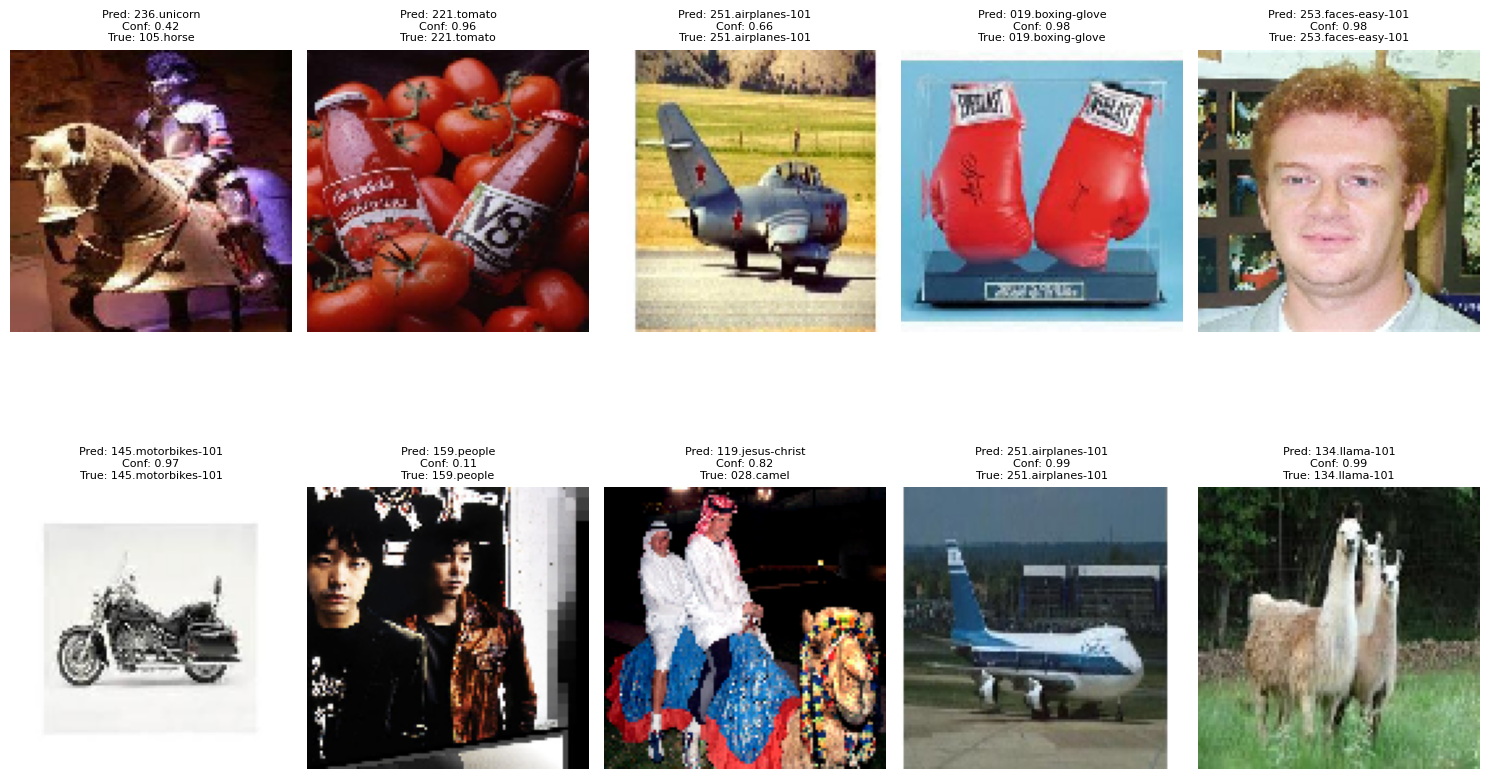

In [ ]:
# --- Display Sample Predictions ---

# Display predictions on 10 random test images
num_images_to_predict = 10
random_indices = np.random.choice(test_images.shape[0], num_images_to_predict, replace=False)
images_to_predict = test_images[random_indices]
true_labels = test_labels[random_indices]

# Preprocess the images for prediction
images_to_predict_preprocessed = preprocess_input(images_to_predict)
predictions = model.predict(images_to_predict_preprocessed)

# Get predicted labels and confidence scores
predicted_labels = np.argmax(predictions, axis=1)
confidence_scores = np.max(predictions, axis=1)

# Display images with predictions and true labels
plt.figure(figsize=(15, 10))
for i in range(num_images_to_predict):
    plt.subplot(2, 5, i + 1)
    # Convert image back for display (clip and cast)
    disp_img = np.clip(images_to_predict[i], 0, 255).astype('uint8')
    plt.imshow(disp_img.astype('uint8'))
    plt.title(f"Pred: {class_names[predicted_labels[i]]}\nConf: {confidence_scores[i]:.2f}\nTrue: {class_names[np.argmax(true_labels[i])]}",
              fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()